<a href="https://colab.research.google.com/github/JFrankVC/aprendizaje_profundo/blob/main/Airplanes_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: *José Francisco Villanueva Cortés*
# Dossier: *742015*

In [1]:
# imports
import torch.nn as nn
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import zipfile
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms, ops
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image, ImageReadMode
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights, alexnet, AlexNet_Weights
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2

In [2]:
# Utilities
WHITE = '\033[97m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

checkpoint_load = True
training_mode = 'TEST'

In [3]:
# Connect drive to verify model storage
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [4]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_DL/Data_DL/airplanes"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_DL/Data_DL/airplanes


In [5]:
!ls

dataset      __MACOSX		 model_cp_airplanes_val
dataset.zip  model_cp_airplanes  model_cp_airplanes_val_giou


In [6]:
#!unzip -u "/content/drive/MyDrive/Colab_DL/Data_DL/airplanes/dataset.zip" -d "/content/drive/MyDrive/Colab_DL/Data_DL/airplanes/"

### Get/read/generate data

In [7]:
transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Resize([256,256]),
            #transforms.RandomVerticalFlip(),
            #transforms.RandomRotation(degrees=15),
            #transforms.Normalize(mean=[0.4664, 0.4891, 0.4104], std=[0.1992, 0.1749, 0.2173]),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            #transforms.Grayscale(num_output_channels=1),
        ])

In [8]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [9]:
def batch_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    return mean,std

In [10]:
# Change to dark-plostyle
plt.style.use('dark_background')

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
pin_mem = True if device.type == "cuda" else False
print(pin_mem)

True


#### Create custom Dataset class

In [13]:
class Dataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, path, new_w, new_h, mode='Train', split_train=0.7, split_val=0.1, shuffle=True):
        # Initialization Validation Dataset
        self.mode = mode
        self.resize = [new_h, new_w] # h, w
        data = ImageFolder(root=path)
        # Create array for storing all ratios
        ratios = []
        # Calculate all ratios
        for image in range(len(data.imgs)):
            original_dims = transforms.functional.get_image_size(data.loader(data.imgs[image][0]))
            ratios.append({'index':(data.imgs[image][0]).split("/")[-1],
                            'w_ratio': new_w / original_dims[0],
                            'h_ratio': new_h / original_dims[1],
                            'path': data.imgs[image][0]})    # [w, h]
        print(f"Ratios len: {len(ratios)}")
        ratios = pd.DataFrame(ratios)
        ratios.set_index('index', inplace=True)

        csv = pd.read_csv("dataset/airplanes.csv", header=None)
        csv.rename(columns={0: 'index', 1: 'x_min', 2: 'y_min', 3: 'x_max', 4: 'y_max'}, inplace=True)
        csv.set_index('index', inplace=True)

        self.df = pd.merge(csv, ratios, left_index=True, right_index=True)
        self.total_samples = len(self.df)

        # Split Train/Test dataframe
        self.df_train, self.df_test = train_test_split(self.df, train_size=split_train, shuffle=shuffle, random_state=123)
        #print(f"Split Train: {self.df_train}, type: {type(self.df_train)}")
        #print(f"Split Test: {self.df_test}, type: {type(self.df_test)}")
        self.train_len = len(self.df_train)
        self.test_len = len(self.df_test)
        print(f"Train Len: {self.train_len}({self.train_len/self.total_samples*100.0:.2f}%) - Test Len: {self.test_len}({self.test_len/self.total_samples*100.0:.2f}%)")
        # Split df_train into two: Train/Val
        self.df_train, self.df_val = train_test_split(self.df_train, train_size=1-split_val, shuffle=shuffle, random_state=123)
        #print(f"Split Train: {self.df_train}, type: {type(self.df_train)}")
        #print(f"Split Val: {self.df_test}, type: {type(self.df_test)}")
        self.train_len = len(self.df_train)
        self.val_len = len(self.df_val)
        print(f"Train Len: {self.train_len}({self.train_len/self.total_samples*100.0:.2f}%) \
                                - Val Len: {self.val_len}({self.val_len/self.total_samples*100.0:.2f}%) \
                                - Test Len: {self.test_len}({self.test_len/self.total_samples*100.0:.2f}%)")


    def __len__(self):
        # Denotes the total number of samples
        if self.mode == 'Train':
            len = self.train_len
        elif self.mode == 'Test':
            len = self.test_len
        else:
            len = self.val_len
        return len

    def __getitem__(self, index):
        # Select sample
        if self.mode == 'Train':
            X = read_image(self.df_train.path[index], ImageReadMode.RGB)
            X = transforms.Resize((self.resize[0], self.resize[1]))(X)
            X = X / 255.0
            bbox = self.df_train.loc[self.df_train.index[index]].to_numpy()[0:4]
            bbox = torch.from_numpy(np.asarray(bbox, dtype=np.float32))
            bbox[0] = bbox[0] * self.df_train.w_ratio[index]
            bbox[1] = bbox[1] * self.df_train.h_ratio[index]
            bbox[2] = bbox[2] * self.df_train.w_ratio[index]
            bbox[3] = bbox[3] * self.df_train.h_ratio[index]
        elif self.mode == 'Test':
            X = read_image(self.df_test.path[index], ImageReadMode.RGB)
            X = transforms.Resize((self.resize[0], self.resize[1]))(X)
            X = X / 255.0
            bbox = self.df_test.loc[self.df_test.index[index]].to_numpy()[0:4]
            bbox = torch.from_numpy(np.asarray(bbox, dtype=np.float32))
            bbox[0] = bbox[0] * self.df_test.w_ratio[index]
            bbox[1] = bbox[1] * self.df_test.h_ratio[index]
            bbox[2] = bbox[2] * self.df_test.w_ratio[index]
            bbox[3] = bbox[3] * self.df_test.h_ratio[index]
        else:
            X = read_image(self.df_val.path[index], ImageReadMode.RGB)
            X = transforms.Resize((self.resize[0], self.resize[1]))(X)
            X = X / 255.0
            bbox = self.df_val.loc[self.df_val.index[index]].to_numpy()[0:4]
            bbox = torch.from_numpy(np.asarray(bbox, dtype=np.float32))
            bbox[0] = bbox[0] * self.df_val.w_ratio[index]
            bbox[1] = bbox[1] * self.df_val.h_ratio[index]
            bbox[2] = bbox[2] * self.df_val.w_ratio[index]
            bbox[3] = bbox[3] * self.df_val.h_ratio[index]

        return X, bbox

In [14]:
os.getcwd()

'/content/drive/MyDrive/Colab_DL/Data_DL/airplanes'

In [15]:
ds_path = 'dataset'

#### Get data for Training, Validation and Testing

In [16]:
data_train = Dataset(path=ds_path, new_w=224, new_h=224, mode='Train', split_train=0.75, split_val=0.1)

Ratios len: 800
Train Len: 600(75.00%) - Test Len: 200(25.00%)
Train Len: 540(67.50%)                                 - Val Len: 60(7.50%)                                 - Test Len: 200(25.00%)


In [17]:
data_val = Dataset(path=ds_path, new_w=224, new_h=224, mode='Val', split_train=0.75, split_val=0.1)

Ratios len: 800
Train Len: 600(75.00%) - Test Len: 200(25.00%)
Train Len: 540(67.50%)                                 - Val Len: 60(7.50%)                                 - Test Len: 200(25.00%)


In [18]:
data_test = Dataset(path=ds_path, new_w=224, new_h=224, mode='Test', split_train=0.75, split_val=0.1)

Ratios len: 800
Train Len: 600(75.00%) - Test Len: 200(25.00%)
Train Len: 540(67.50%)                                 - Val Len: 60(7.50%)                                 - Test Len: 200(25.00%)


In [19]:
# Measure lenght of datasets - must add up to 800 initial samples
data_train.__len__(), data_val.__len__(), data_test.__len__()

(540, 60, 200)

#### Verify datasets

In [20]:
X_train, bbox_train = data_train.__getitem__(539)
X_train, bbox_train

(tensor([[[0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9882, 0.9961, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [0.9882, 0.9961, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [0.9882, 0.9961, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 0.9961, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9961, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9961, 0.9843,  ...,

In [21]:
X_val, bbox_val = data_val.__getitem__(59)
X_val, bbox_val

(tensor([[[0.3451, 0.3451, 0.3451,  ..., 0.3412, 0.3451, 0.3490],
          [0.3490, 0.3451, 0.3451,  ..., 0.3451, 0.3451, 0.3490],
          [0.3490, 0.3451, 0.3412,  ..., 0.3490, 0.3490, 0.3529],
          ...,
          [0.3098, 0.3176, 0.3176,  ..., 0.4275, 0.4157, 0.4235],
          [0.3020, 0.3059, 0.3137,  ..., 0.4235, 0.4118, 0.4196],
          [0.2941, 0.2980, 0.3137,  ..., 0.4235, 0.4118, 0.4196]],
 
         [[0.4784, 0.4784, 0.4784,  ..., 0.4745, 0.4784, 0.4824],
          [0.4824, 0.4784, 0.4784,  ..., 0.4784, 0.4784, 0.4824],
          [0.4824, 0.4784, 0.4745,  ..., 0.4824, 0.4824, 0.4863],
          ...,
          [0.3333, 0.3412, 0.3412,  ..., 0.4000, 0.3804, 0.3843],
          [0.3255, 0.3294, 0.3373,  ..., 0.3882, 0.3686, 0.3725],
          [0.3176, 0.3216, 0.3373,  ..., 0.3843, 0.3686, 0.3686]],
 
         [[0.5765, 0.5765, 0.5765,  ..., 0.5725, 0.5765, 0.5804],
          [0.5804, 0.5765, 0.5765,  ..., 0.5765, 0.5765, 0.5804],
          [0.5804, 0.5765, 0.5725,  ...,

In [22]:
X_train.shape, X_val.shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

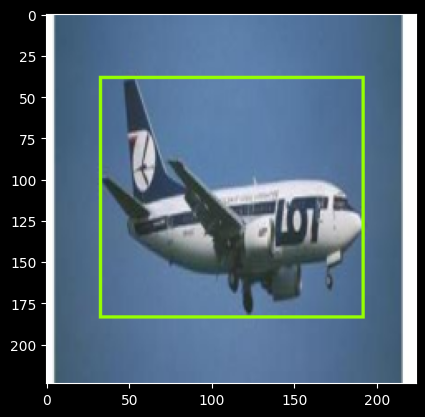

In [23]:
bbox_train = bbox_train.unsqueeze(0)
img_bbox = draw_bounding_boxes((X_train*255).to(dtype=torch.uint8), bbox_train, colors=(150,255,0), width=2)
plt.imshow(img_bbox.permute(1, 2, 0))

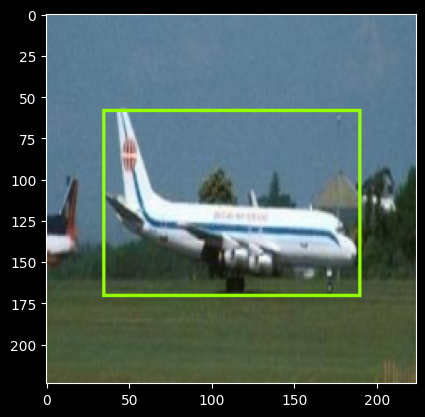

In [24]:
bbox_val = bbox_val.unsqueeze(0)
img_bbox = draw_bounding_boxes((X_val*255).to(dtype=torch.uint8), bbox_val, colors=(150,255,0), width=2)
plt.imshow(img_bbox.permute(1, 2, 0))

In [25]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=24, shuffle=True, num_workers=1)
data_loader_val = torch.utils.data.DataLoader(dataset=data_val, batch_size=8, shuffle=True, num_workers=1)

In [26]:
batch_x, batch_bbox = next(iter(data_loader_train))
print(batch_x, batch_bbox)

tensor([[[[0.9333, 0.5255, 0.3804,  ..., 0.3804, 0.3843, 0.3882],
          [0.9333, 0.5255, 0.3804,  ..., 0.3804, 0.3804, 0.3843],
          [0.9333, 0.5255, 0.3804,  ..., 0.3765, 0.3765, 0.3765],
          ...,
          [0.9412, 0.4431, 0.3098,  ..., 0.3216, 0.3294, 0.3255],
          [0.9451, 0.4471, 0.3176,  ..., 0.3137, 0.3216, 0.3176],
          [0.9451, 0.4471, 0.3176,  ..., 0.3098, 0.3137, 0.3098]],

         [[0.9608, 0.5922, 0.5020,  ..., 0.4980, 0.5020, 0.5059],
          [0.9608, 0.5922, 0.5020,  ..., 0.4980, 0.4980, 0.5020],
          [0.9608, 0.5922, 0.5020,  ..., 0.4941, 0.4941, 0.4941],
          ...,
          [0.9490, 0.4588, 0.3373,  ..., 0.3412, 0.3451, 0.3451],
          [0.9490, 0.4667, 0.3451,  ..., 0.3294, 0.3333, 0.3294],
          [0.9490, 0.4667, 0.3451,  ..., 0.3176, 0.3216, 0.3176]],

         [[0.9647, 0.6118, 0.5176,  ..., 0.5373, 0.5412, 0.5451],
          [0.9647, 0.6118, 0.5176,  ..., 0.5373, 0.5373, 0.5412],
          [0.9647, 0.6118, 0.5176,  ..., 0

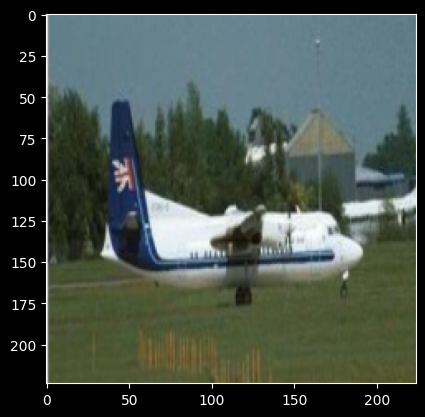

In [27]:
plt.imshow(batch_x[0].permute(1, 2, 0))

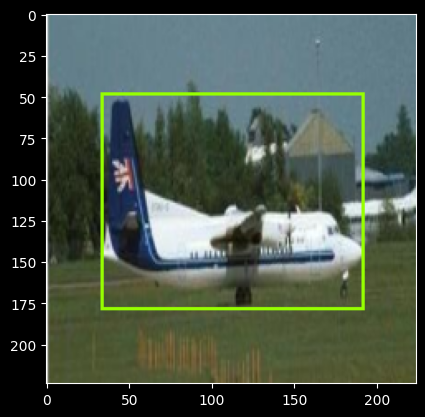

In [28]:
img_bbox = draw_bounding_boxes((batch_x[0]*255).to(dtype=torch.uint8), batch_bbox[0].unsqueeze(0), colors=(150,255,0), width=2)
plt.imshow(img_bbox.permute(1, 2, 0))

In [29]:
#next(model.parameters()).is_cuda

### BBox Regression Model

In [30]:
from torchvision import models

In [31]:
torch.cuda.empty_cache()

#### Create RegressionModel class for Bbox regression

Regression Model (ANN) uses as base, pre-trained (`DEFAULT` weights) VGG16 network. Decision is taken for two resons, first, to try to make it work as in previous assignment for classification this model was not usefulr for the author (either because the model does not perform well for segmentation, or because the author was not experienced enough to adjust the model to the problem), and second, to test the use of a convolutional model for regression instead of classification.

In [32]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        # VGG16 base model
        net = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.net_01 = net.features
        self.regressor_01 = net.classifier
        self.regressor_01[3] = nn.Linear(in_features=4096, out_features=512, bias=True)
        self.regressor_01[6] = nn.Linear(in_features=512, out_features=4, bias=True)

    def forward(self, x):
        out_bbox = self.net_01(x)
        out_bbox = torch.flatten(out_bbox)
        out_bbox = self.regressor_01(out_bbox)

        return out_bbox

In [33]:
if training_mode == 'TRAIN':
    model_bbox_reg = RegressionModel()

In [34]:
# Freeze VGG feature layers
for param in model_bbox_reg.net_01.parameters():
    param.requires_grad = False

NameError: name 'model_bbox_reg' is not defined

In [35]:
# Verify regressor layers are ready for training
if training_mode == 'TRAIN':
    for param in model_bbox_reg.parameters():
        print(param.requires_grad)

In [36]:
if training_mode == 'TRAIN':
    #free cuda
    torch.cuda.empty_cache()

In [37]:
if training_mode == 'TRAIN':
    model_bbox_reg.cuda()

In [38]:
if training_mode == 'TRAIN':
    # check if model in gpu
    next(model_bbox_reg.parameters()).is_cuda

In [39]:
if training_mode == 'TRAIN':
    optim_reg = torch.optim.Adam(model_bbox_reg.parameters(), lr=0.0001) # Adam optmizer
    loss_reg = nn.MSELoss() # Mean squared error loss

In [40]:
model_bbox_reg

NameError: name 'model_bbox_reg' is not defined

In [41]:
# Create data loaders
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=1, shuffle=True, num_workers=1) # Testing
data_loader_val = torch.utils.data.DataLoader(dataset=data_val, batch_size=1, shuffle=True, num_workers=1) # Validation

In [42]:
# Train model

def train_clas(model, epochs, batch_size, loss_fn, optimizer, data_train_loader, data_val_loader, validation, checkpoint_path):
    loss_history = []
    val_loss_history = []
    img_not_fixed = True
    running_loss = 0.0
    running_val_loss = 0.0
    #weigths_species = torch.ones(14, dtype=torch.float32).to(device=device)
    #weigths_species = weigths_species / torch.sum(weigths_species)

    for epoch in range(epochs):
        # Training
        model.train()
        # Freeze VGG feature layers
        for param in model.net_01.parameters():
            param.requires_grad = False
        print(f"{WHITE}Epoch {YELLOW}{epoch+1}{RESET} started")
        batch_x, batch_y = next(iter(data_train_loader))
        print(f"{WHITE}Batch X: {YELLOW}{np.shape(batch_x)}{RESET}")

        # Get fixed image for printing
        if img_not_fixed:
            img = batch_x
            img_bbox = batch_y
            img_not_fixed = False

            plt.figure(figsize=(15, 8))

            plt.subplot(1, 2, 1)
            print(img[0].shape)
            plt.imshow(img[0].permute(1, 2, 0))
            plt.title(f"Image - BBOX: {img_bbox[0]}")


        # Clear out the gradient
        optimizer.zero_grad()

        # Pass to cuda device
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.float32)

        # Forward pass through the network
        output_bbox = model(batch_x)
        print(f"{WHITE}output_bbox: {YELLOW}{output_bbox}{RESET}")

        output_bbox = output_bbox.to(dtype=torch.float32)

        # Pass to cpu
        batch_x = batch_x.to('cpu')
        output_bbox = output_bbox.to('cpu')
        batch_y = batch_y.to('cpu')

        print(f"{WHITE}y_bbox: {YELLOW}{batch_y}{RESET}")

        torch.cuda.empty_cache()

        # Calculate loss
        #loss_reg = loss_fn(output_bbox.to(dtype=torch.float32), batch_y.to(dtype=torch.float32))
        loss_reg = loss_fn(output_bbox.to(dtype=torch.float32), batch_y[0].to(dtype=torch.float32))

        #loss_reg = loss_reg.mean()
        print(f"{WHITE}Train Batch Loss: {YELLOW}{loss_reg}{RESET}")

        # Compute the gradient
        loss_reg.backward()

        print(f"{WHITE}Train Batch Total Loss: {YELLOW}{loss_reg}{RESET}")

        # Update the weights
        optimizer.step()
        running_loss += loss_reg.item()
        loss_history.append((loss_reg.item(), running_loss))

        torch.cuda.empty_cache()

        # Validation
        if epoch % 10 == 0 and validation == True: # Each 10 epochs do validation
            model.eval()

            batch_val_x, batch_val_y = next(iter(data_val_loader))

             # Pass to cuda device
            batch_val_x = batch_val_x.to(device=device, dtype=torch.float32)
            batch_val_y = batch_val_y.to(device=device, dtype=torch.float32)

            # Forward pass through the network
            output_val_bbox = model(batch_val_x)

            output_val_bbox = output_bbox.to(dtype=torch.float32)

            # Pass to cpu
            batch_val_x = batch_val_x.to('cpu')
            output_val_bbox = output_val_bbox.to('cpu')
            batch_val_y = batch_val_y.to('cpu')

            # Calculate validation loss
            #loss_val = loss_fn(output_bbox.to(dtype=torch.float32), batch_y.to(dtype=torch.float32))
            loss_val = loss_fn(output_val_bbox.to(dtype=torch.float32), batch_val_y[0].to(dtype=torch.float32))
            running_val_loss += loss_val.item()
            val_loss_history.append((loss_val.item(), running_val_loss))

            print(f"{WHITE}Validation Batch Loss: {GREEN}{loss_val}{RESET}")

    # Save the model
    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)

    return loss_history, val_loss_history

In [43]:
# Verify data loaders
batch_x, batch_y = next(iter(data_loader_train))
batch_x.shape, batch_y.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 4]))

In [44]:
batch_x, batch_y = next(iter(data_loader_val))
batch_x.shape, batch_y.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 4]))

In [45]:
# Start training
if training_mode == 'TRAIN':
    loss_history = train_clas(model_bbox_reg, 550, 1, loss_reg, optim_reg, data_loader_train, data_loader_val, True, 'model_cp_airplanes_val')

In [46]:
if training_mode == 'TRAIN':
    # Plot losses vs epochs
    plt.plot([loss_history[0][i][0] for i in range(len(loss_history[0]))], 'y')
    #plt.plot(val_loss_history, 'g--')
    plt.legend(['Loss'])#, 'Val Loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [47]:
if training_mode == 'TRAIN':
    # Plot losses vs epochs
    plt.plot([loss_history[1][i][0] for i in range(len(loss_history[1]))], 'y')
    #plt.plot(val_loss_history, 'g--')
    plt.legend(['Val Loss'])#, 'Val Loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Val Loss")
    plt.show()

### Test model on Test split images and checkpoint model

In [48]:
model_bbox_reg = RegressionModel()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.9MB/s]


In [49]:
checkpoint = torch.load('model_cp_airplanes_val')

In [ ]:
checkpoint

In [51]:
model_bbox_reg.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=200, shuffle=True, num_workers=1)

In [53]:
batch_x_test, batch_y_test = next(iter(data_loader_test))

In [ ]:
# Eval mode
model_bbox_reg.cuda()
# check if model in gpu
print(next(model_bbox_reg.parameters()).is_cuda)
model_bbox_reg.eval()

In [55]:
# Free cuda
torch.cuda.empty_cache()

In [56]:
pred_bbox = model_bbox_reg(batch_x_test[0].to(device).to(dtype=torch.float32))

In [57]:
def create_mask(bbox):
    mask = np.zeros((224,224),dtype=np.uint8) # initialize mask
    bbox = bbox.to(dtype=torch.uint8)
    mask[bbox[1]:bbox[3],bbox[0]:bbox[2]] = 255 # fill with white pixels
    return mask

In [58]:
def IoU_metric(pred_bbox, ground_t_bbox):
    # 1)
    x_hat_1 = torch.min(pred_bbox[0], pred_bbox[2])
    x_hat_2 = torch.max(pred_bbox[0], pred_bbox[2])
    y_hat_1 = torch.min(pred_bbox[1], pred_bbox[3])
    y_hat_2 = torch.max(pred_bbox[1], pred_bbox[3])
    # 2)
    A_g = (ground_t_bbox[2] - ground_t_bbox[0]) * (ground_t_bbox[3] - ground_t_bbox[1])
    # 3)
    A_p = (x_hat_2 - x_hat_1) * (y_hat_2 - y_hat_1)
    # 4)
    x_I_1 = torch.max(x_hat_1, ground_t_bbox[0])
    x_I_2 = torch.max(x_hat_2, ground_t_bbox[2])
    y_I_1 = torch.max(y_hat_1, ground_t_bbox[1])
    y_I_2 = torch.max(y_hat_2, ground_t_bbox[3])

    if (x_I_2 > x_I_1) and (y_I_2 > y_I_1):
        I = (x_I_2 - x_I_1) * (y_I_2 - y_I_1)
    else:
        I = 0
    # 5)
    U = A_p + A_g - I
    IoU = I/U

    return IoU

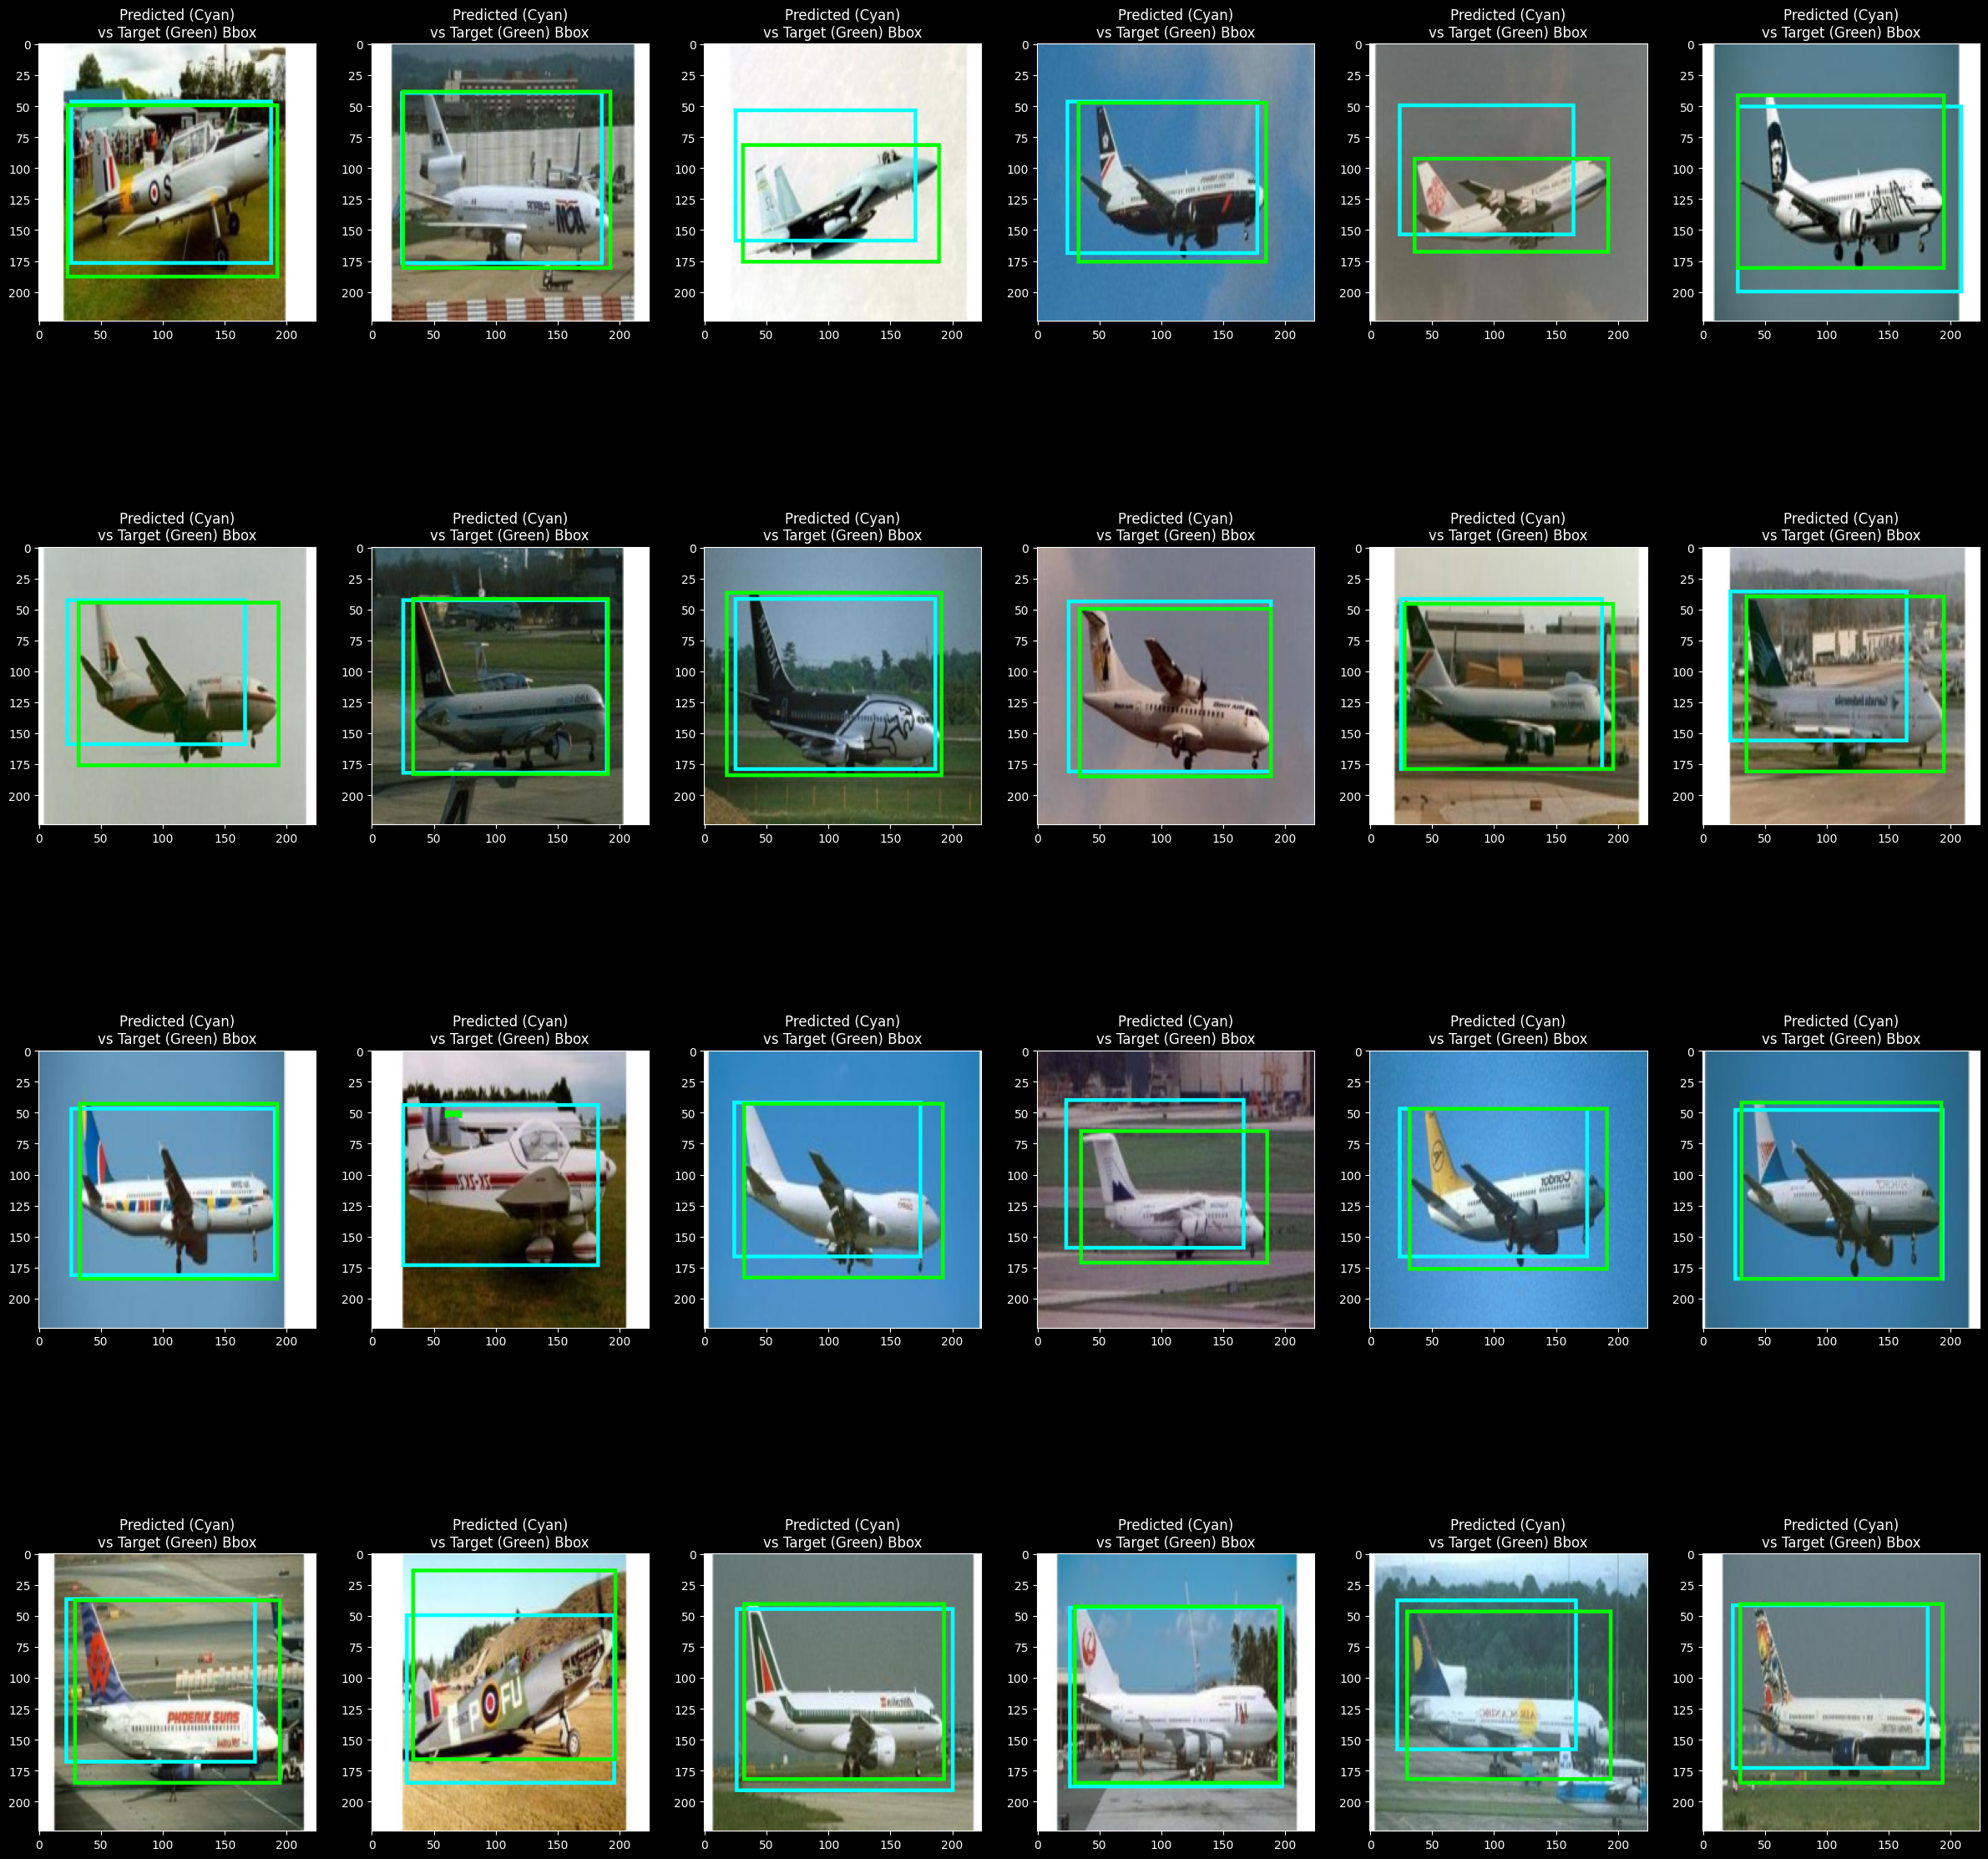

In [59]:
# Predicting an annotated image
fig, axs = plt.subplots(4, 6, figsize=(30, 30))
# Masks storage
masks = []
IoU_metrics = []
for i in range(4):
    for j in range(6):
        pred_bbox = model_bbox_reg(batch_x_test[i*6+j].to(device).to(dtype=torch.float32))
        # Resize bbox by using ratios

        # Add predicted bbox (blue)
        img_bbox = draw_bounding_boxes((batch_x_test[i*6+j]*255).to(dtype=torch.uint8), pred_bbox.unsqueeze(0), colors=(0,255,255), width=3)
        axs[i, j].imshow(img_bbox.permute(1, 2, 0))
        # Create predicted mask
        mask_pred = create_mask(pred_bbox)

        # Add target bbox (green)
        img_bbox = draw_bounding_boxes(img_bbox, batch_y_test[i*6+j].unsqueeze(0), colors=(0,255,0), width=3)
        axs[i, j].imshow(img_bbox.permute(1, 2, 0))
        mask_target = create_mask(batch_y_test[i*6+j])

        # Store masks as [pred, target] masks
        masks.append([mask_pred, mask_target])

        axs[i, j].set_title('Predicted (Cyan)\nvs Target (Green) Bbox')

        # Calculate IoU
        iou_metric = IoU_metric(pred_bbox, batch_y_test[i*6+j])
        IoU_metrics.append(iou_metric.item())


In [60]:
IoU_metrics

[1.0688414573669434,
 1.056665062904358,
 0.9847081303596497,
 1.0340540409088135,
 0.8082034587860107,
 1.1686629056930542,
 1.2651983499526978,
 0.968636691570282,
 0.9950845241546631,
 0.9334520697593689,
 1.0139257907867432,
 1.3088749647140503,
 0.9658569097518921,
 2.714808702468872,
 1.1995750665664673,
 0.9231212735176086,
 1.1429779529571533,
 0.9400142431259155,
 1.2179133892059326,
 0.8717690706253052,
 1.0417883396148682,
 0.9986096024513245,
 1.2849128246307373,
 1.124086618423462]

#### Test metrics (IoU)

In [61]:
batch_x_test, batch_y_test = next(iter(data_loader_test))

In [62]:
# Calculate IoU for full test dataset
IoU_metrics = []
for j in range(batch_x_test.shape[0]):
    pred_bbox = model_bbox_reg(batch_x_test[j].to(device).to(dtype=torch.float32))

    # Calculate IoU
    iou_metric = IoU_metric(pred_bbox, batch_y_test[j])
    IoU_metrics.append(iou_metric.item())

In [63]:
mean_IoU = np.array(IoU_metrics)
print(f"{WHITE}IoU metrics len: {YELLOW}{mean_IoU.shape}{RESET}")
mean_IoU = torch.tensor(IoU_metrics)
mean_IoU = mean_IoU.mean()
print(f"{WHITE}Intersection over Union metric (batch mean): {YELLOW}{mean_IoU:.2f}{RESET}")

IoU metrics len: (200,)
Intersection over Union metric (batch mean): 1.08


### Test model (New images)

In [64]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_DL/Data_DL/airplanes_test"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content/drive/MyDrive/Colab_DL/Data_DL/airplanes
Current working directory /content/drive/MyDrive/Colab_DL/Data_DL/airplanes_test


In [65]:
class DatasetTest(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, path, new_w, new_h):
        # Initialization Validation Dataset
        self.resize = [new_h, new_w] # h, w
        data = ImageFolder(root=path)
        # Create array for storing all ratios
        ratios = []
        # Calculate all ratios
        for image in range(len(data.imgs)):
            original_dims = transforms.functional.get_image_size(data.loader(data.imgs[image][0]))
            ratios.append({'index':(data.imgs[image][0]).split("/")[-1],
                            'w_ratio': new_w / original_dims[0],
                            'h_ratio': new_h / original_dims[1],
                            'path': data.imgs[image][0]})    # [w, h]
        print(f"Ratios len: {len(ratios)}")
        self.ratios = pd.DataFrame(ratios)
        self.ratios.set_index('index', inplace=True)

        #csv = pd.read_csv("dataset/airplanes.csv", header=None)
        #csv.rename(columns={0: 'index', 1: 'x_min', 2: 'y_min', 3: 'x_max', 4: 'y_max'}, inplace=True)
        #csv.set_index('index', inplace=True)

        #self.df = pd.merge(csv, ratios, left_index=True, right_index=True)

        # Create array for bbox
        #self.bboxes = torch

    def __len__(self):
        # Denotes the total number of samples
        return len(self.ratios)

    def __getitem__(self, index):
        # Select sample
        X = read_image(self.ratios.path[index], ImageReadMode.RGB)
        X = transforms.Resize((self.resize[0], self.resize[1]))(X)
        X = X / 255.0
        print(f"Path: {self.ratios.path[index]}")

        return X

In [66]:
ds_test_path = 'dataset'
data_test = DatasetTest(path=ds_test_path, new_w=224, new_h=224)

Ratios len: 4


In [67]:
data_test.ratios

w_ratio   h_ratio                                path
index                                                                      
image_tst_0001.jpeg  0.075421  0.122807  dataset/images/image_tst_0001.jpeg
image_tst_0002.jpeg  0.746667  1.333333  dataset/images/image_tst_0002.jpeg
image_tst_0003.jpeg  0.814545  1.224044  dataset/images/image_tst_0003.jpeg
image_tst_0004.jpeg  0.704403  1.408805  dataset/images/image_tst_0004.jpeg

In [68]:
data_test.ratios.w_ratio[0]

0.07542087542087542

In [69]:
data_loader_tst = torch.utils.data.DataLoader(dataset=data_test, batch_size=1, shuffle=True, num_workers=1)

In [70]:
batch_x = next(iter(data_loader_tst))

Path: dataset/images/image_tst_0003.jpeg
Path: dataset/images/image_tst_0001.jpeg


In [71]:
batch_x

tensor([[[[0.5255, 0.5373, 0.5569,  ..., 0.8627, 0.8588, 0.8588],
          [0.5176, 0.5294, 0.5490,  ..., 0.8588, 0.8549, 0.8549],
          [0.4980, 0.5137, 0.5333,  ..., 0.8588, 0.8510, 0.8510],
          ...,
          [0.5098, 0.5137, 0.5176,  ..., 0.5216, 0.5098, 0.5098],
          [0.5098, 0.5137, 0.5176,  ..., 0.5176, 0.5098, 0.5098],
          [0.5098, 0.5098, 0.5137,  ..., 0.5020, 0.5059, 0.5059]],

         [[0.5804, 0.5922, 0.6000,  ..., 0.8275, 0.8235, 0.8235],
          [0.5804, 0.5843, 0.5922,  ..., 0.8235, 0.8196, 0.8196],
          [0.5765, 0.5804, 0.5882,  ..., 0.8235, 0.8157, 0.8157],
          ...,
          [0.4392, 0.4431, 0.4471,  ..., 0.4510, 0.4392, 0.4392],
          [0.4392, 0.4431, 0.4471,  ..., 0.4471, 0.4392, 0.4392],
          [0.4392, 0.4392, 0.4431,  ..., 0.4314, 0.4353, 0.4353]],

         [[0.7333, 0.7333, 0.7294,  ..., 0.8471, 0.8392, 0.8353],
          [0.7373, 0.7333, 0.7333,  ..., 0.8431, 0.8353, 0.8314],
          [0.7373, 0.7373, 0.7373,  ..., 0

In [72]:
model_bbox_reg.eval()

RegressionModel(
  (net_01): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [73]:
pred_bbox = model_bbox_reg(batch_x[0].to(device).to(dtype=torch.float32))

In [74]:
pred_bbox

tensor([ 25.4471,  45.4822, 186.1638, 176.6380], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [ ]:
image = 3
pred_bbox[0] = pred_bbox[0] / data_test.ratios.w_ratio[image]
pred_bbox[1] = pred_bbox[1] / data_test.ratios.h_ratio[image]
pred_bbox[2] = pred_bbox[2] / data_test.ratios.w_ratio[image]
pred_bbox[3] = pred_bbox[3] / data_test.ratios.h_ratio[image]

In [ ]:
# Predicting an annotated image
#img_bbox = draw_bounding_boxes(batch_x[0], batch_y[0].unsqueeze(0), colors=(150,255,0), width=2)
#plt.imshow(img_bbox.permute(1, 2, 0))

In [ ]:
# Predicting an annotated image
#img_bbox = draw_bounding_boxes(batch_x[0], pred_bbox.unsqueeze(0), colors=(255,150,0), width=2)
#plt.imshow(img_bbox.permute(1, 2, 0))

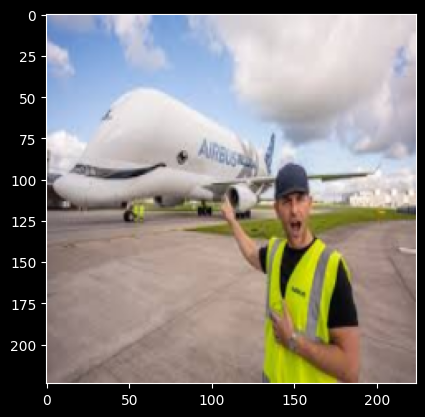

In [75]:
# Predicting an non-annotated image
plt.imshow(batch_x[0].permute(1, 2, 0))

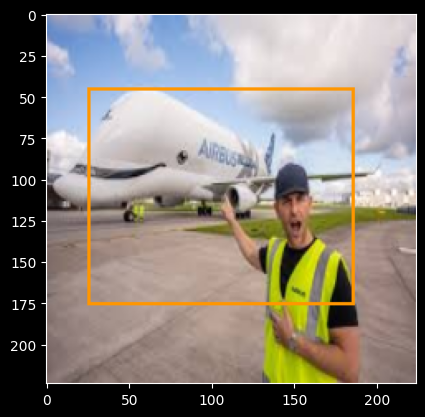

In [76]:
# Predicting an annotated image
img_bbox = draw_bounding_boxes((batch_x[0] * 255).to(dtype=torch.uint8), pred_bbox.unsqueeze(0), colors=(255,150,0), width=2)
plt.imshow(img_bbox.permute(1, 2, 0))

In [77]:
#os.getcwd()

'/content/drive/MyDrive/Colab_DL/Data_DL/airplanes_test'

In [78]:
# Change the directory - Google Drive
#path = "/content/drive/MyDrive/Colab_DL"
#os.chdir(path)

In [79]:
#!jupyter nbconvert Airplanes_DL.ipynb --to html

[NbConvertApp] Converting notebook Airplanes_DL.ipynb to html
[NbConvertApp] Writing 1936382 bytes to Airplanes_DL.html


In [80]:
#!ls

Airplanes_DL.html	Data_DL		   Feuilles_Grey_densenet_DL.ipynb  Models_DL
Airplanes_DL_IoU.html	DL_01.ipynb	   Feuilles_Grey_DL.ipynb	    Models_DLmymodel
Airplanes_DL_IoU.ipynb	Examen_I	   model_instance_01		    Music_DL.ipynb
Airplanes_DL.ipynb	Feuilles_DL.ipynb  model_instance_02		    StyleTransfer_DL.ipynb
